In [61]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report
from tensorflow.keras.regularizers import l2

In [63]:
IMG_SIZE = (128, 128)

def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Failed to load image {img_path}")
                continue  #skipping jo image not opening
            
            img = cv2.resize(img, IMG_SIZE)
            img = img.astype("float32") / 255.0  #normalizingg
            images.append(img)
    
    return images

In [67]:
#training data
real_docs_train = load_images("augmented/train/real")
tampered_docs_train = load_images("augmented/train/fake")
#testing data
real_docs_test = load_images("augmented/test/real")
tampered_docs_test = load_images("augmented/test/fake") 

In [68]:
real_docs_train = np.expand_dims(real_docs_train, axis=-1)
tampered_docs_train = np.expand_dims(tampered_docs_train, axis=-1)
real_docs_test = np.expand_dims(real_docs_test, axis=-1)
tampered_docs_test = np.expand_dims(tampered_docs_test, axis=-1)
#expanding dimension cnn ke liye (tf requires 4 ip for cnn) ie (numsize,128,128,1) 1 for greyscale channel

In [69]:
X_train = real_docs_train

In [73]:
input_layer = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
#encoder
x = Conv2D(64, (3, 3), activation="relu", padding="same",kernel_regularizer=l2(0.001))(input_layer)
x = Dropout(0.2)(x)
x = MaxPooling2D((2, 2), padding="same")(x) #downsampling
x = Conv2D(64, (3, 3), activation="relu", padding="same",kernel_regularizer=l2(0.001))(x)
x = Dropout(0.2)(x)
x = MaxPooling2D((2, 2), padding="same")(x)
#decoder
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
output_layer = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")

In [77]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
]
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.1,callbacks=callbacks,shuffle = True)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step - loss: 0.1806 - val_loss: 0.1459 - learning_rate: 5.0000e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - loss: 0.1546 - val_loss: 0.1336 - learning_rate: 5.0000e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step - loss: 0.1320 - val_loss: 0.1234 - learning_rate: 5.0000e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step - loss: 0.1223 - val_loss: 0.1211 - learning_rate: 5.0000e-04
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step - loss: 0.1248 - val_loss: 0.1193 - learning_rate: 5.0000e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - loss: 0.1211 - val_loss: 0.1160 - learning_rate: 5.0000e-04
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step - loss: 0.1161 - val_loss: 0.1152 - learning_rate: 5.0000e-04
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step - loss: 0.1134 - val_loss: 0.1154 - learning_rate: 5.0000e-04
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 447ms/step - loss: 0.1127 - val_loss: 0.1121 - learning_

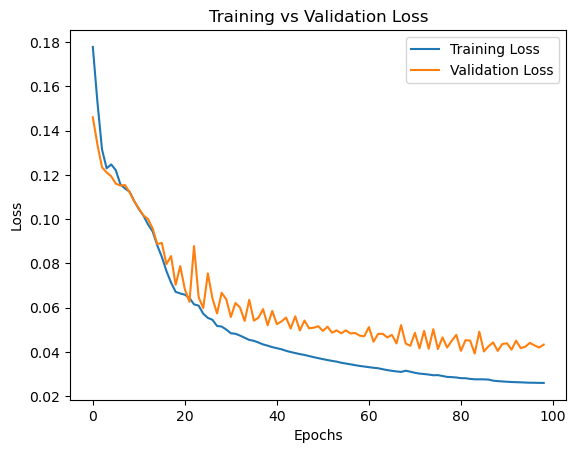

In [78]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [79]:
def compute_reconstruction_error(model, images):
    reconstructions = model.predict(images)
    errors = np.mean(np.abs(reconstructions - images), axis=(1, 2, 3))  # Mean Absolute Error per image
    return errors

In [80]:
real_errors_train = compute_reconstruction_error(autoencoder, real_docs_train)
tampered_errors_train = compute_reconstruction_error(autoencoder, tampered_docs_train)
#getting reconstruction error training data se

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


In [81]:
threshold = np.percentile(real_errors_train, 85)
#threshold using percentile of real document errors 

In [82]:
real_errors_test = compute_reconstruction_error(autoencoder, real_docs_test)
tampered_errors_test = compute_reconstruction_error(autoencoder, tampered_docs_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


In [83]:
#0 real 1 fakee
labels_test = np.concatenate((np.zeros(len(real_errors_test)), np.ones(len(tampered_errors_test))))
predictions_test = np.concatenate((real_errors_test, tampered_errors_test))

In [84]:
#receiver operating characteristic (True Positive Rate (TPR) vs. False Positive Rate (FPR)) - area under curve area under the ROC curve
fpr, tpr, _ = roc_curve(labels_test, predictions_test)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(labels_test, predictions_test)
pr_auc = auc(recall, precision)

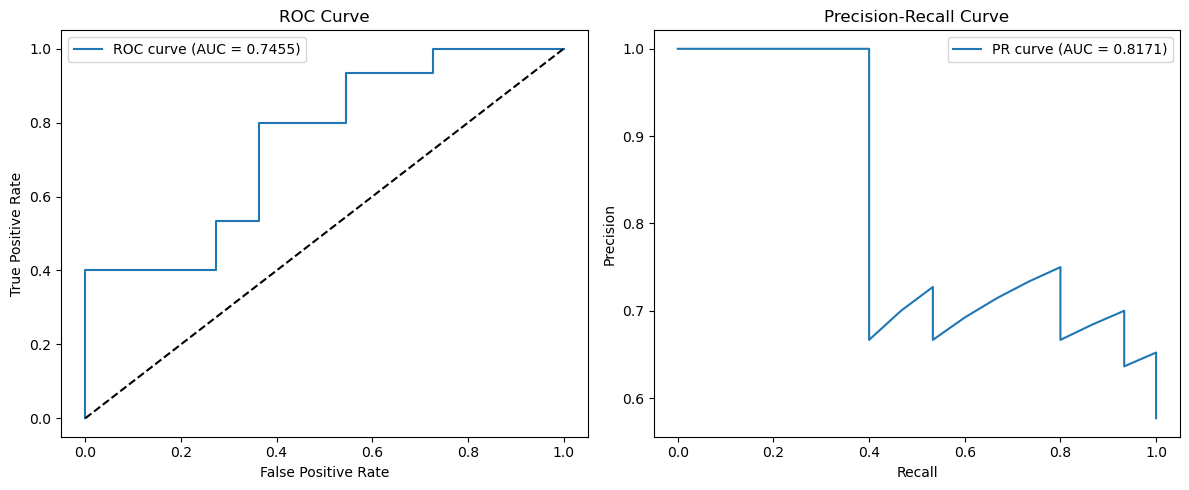

In [85]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [86]:
# plt.figure(figsize=(10, 5))
# sns.histplot(real_errors_test, kde=True, color='blue', label='Real docs')
# sns.histplot(tampered_errors_test, kde=True, color='red', label='Tampered docs')
# plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
# plt.xlabel('Reconstruction error')
# plt.ylabel('freq')
# plt.title('Reconstruction Error Distribution')
# plt.legend()
# plt.show()

In [87]:
predicted_labels_test = (predictions_test > threshold).astype(int)

In [88]:
print("Classification Report:")
print(classification_report(labels_test, predicted_labels_test))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.91      0.67        11
         1.0       0.86      0.40      0.55        15

    accuracy                           0.62        26
   macro avg       0.69      0.65      0.61        26
weighted avg       0.72      0.62      0.60        26



In [89]:
print(f'Threshold: {threshold:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Precision-Recall AUC: {pr_auc:.4f}')

Threshold: 0.1559
ROC AUC: 0.7455
Precision-Recall AUC: 0.8171


In [90]:
def predict_new_image(image_path, model, threshold):
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype("float32") / 255.0  
    img = np.expand_dims(img, axis=(0, -1))  

    reconstructed_img = model.predict(img)

    error = np.mean(np.abs(reconstructed_img - img))

    result = "Tampered" if error > threshold else "Real"

    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img.squeeze(), cmap='gray')
    plt.title("Reconstructed Image")
    plt.axis("off")

    plt.show()

    print(f"Reconstruction Error: {error:.4f}")
    print(f"Predicted Label: {result}")

    return result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


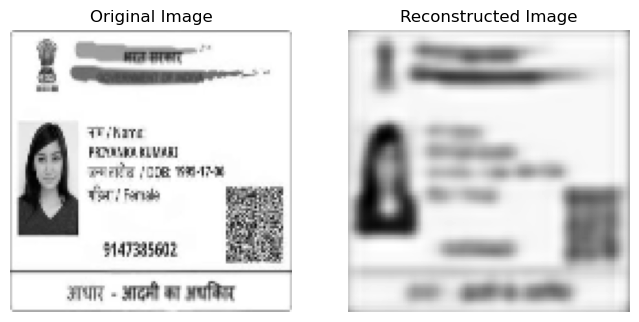

Reconstruction Error: 0.1760
Predicted Label: Tampered


In [92]:
result = predict_new_image("aadhar_fake.jpg", autoencoder, threshold)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


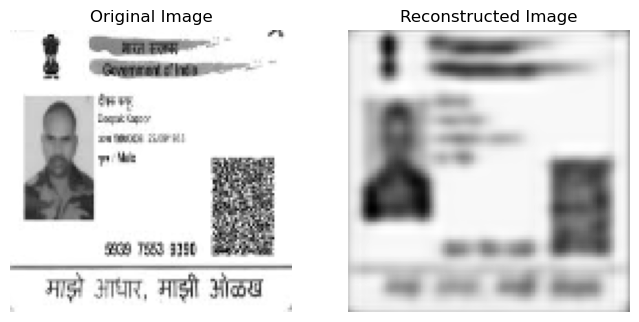

Reconstruction Error: 0.1743
Predicted Label: Tampered


In [96]:
result = predict_new_image("fakeadhaar.jpg", autoencoder, threshold)

In [ ]:
from tensorflow import keras

In [ ]:
autoencoder.save('my_adhaar_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
loaded_model = load_model('my_adhaar_model.keras')